<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/04_03_VAE_latent_space_CONV_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실습 4-3 : Variable Auto Encoder with CNN** 

>#### - Latent Variables (잠재 변수)가 갖고 있는 특징을 잘  표현하는 Decoder와  ​
>#### - 학습을 통해 Data와 Latent Variable간에  mapping을 잘 하는 Encoder의 결합​

## **Import Module**

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, utils

from tensorflow.keras import backend as K
import numpy as np

tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## **DataSet**

### Load

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
print(x_train.shape, x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


### Preprocessing

In [0]:
# normalize
x_train, x_test = x_train / 255., x_test / 255.
# add a channel dimension
x_train, x_test = x_train[..., tf.newaxis], x_test[..., tf.newaxis] #(???,1)<-(???)


Dimension expansion :   
1) x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # [bs H W C]   
2) x_train, x_test = x_train[..., tf.newaxis], x_test[..., tf.newaxis]  
3) X_train = np.expand_dims(X_train, axis=-1)  

In [0]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## **Model**

## Encoder: $q_{\phi}({\cdot})$

> 역활 : 데이터가 주어졌을 때 Decoder가 원래의 데이터로 잘 복원할 수 있는  
 z 를 샘플링 할 수 있는 이상적인 확률분포  $p(z|x)$ 를 찾는 것   
> 어떤 것이 이상적인 확률분포  p(z|x)  인지는 아무도 모름    
> #### VAE 방법론에서는 이 문제를 해결하기 위해 Variational inference(변분 추론)을 사용한다.

In [0]:
# encoder
img_shape = (28, 28, 1)
latent_dim = 2

input_layer = layers.Input(shape=img_shape)

e = layers.Conv2D(32, 3, padding='same', activation='relu')(input_layer)
e = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(e)
e = layers.Conv2D(64, 3, padding='same', activation='relu')(e)
e = layers.Conv2D(64, 3, padding='same', activation='relu')(e) #(14,14,64)

shape_before_flattening = K.int_shape(e)
flat = layers.Flatten()(e) #(12544)<-(14,14,64)
x = layers.Dense(32, activation='relu')(flat)

# 가정한 확률분포의 모수
z_mean = layers.Dense(latent_dim)(x)    #(2)<-(32) 
z_log_var = layers.Dense(latent_dim)(x) #(2)<-(32) 

## Sampling
### - Encoder 출력: $𝑞_𝜙(𝑧|𝑥)$ 확률 분포의 모수 
### - $𝑞_𝜙(𝑧|𝑥)$ 를 정규 분포라고 가정: 평균과 분산
### - 다음 단계는 이 확률분포로 부터 샘플링
> - 이 때, $𝑧$ 를 확률분포에서 그냥 샘플링 한다면 Back propagation 시 체인룰이 중간에 끊김. (편미분 불가)
> - 이를 극복하기 위해서 Reparameterization trick 사용

## Reparameterization trick: 
>### 가우시안 정규 분포의 샘플을 추출 시 아래의 식과 같이 샘플링

>>### $𝑧^{𝑖,𝑙}\tilde{ }𝑁(𝜇_𝑖,𝜎^2_𝑖)→𝑧^{𝑖,𝑙}=𝜇_𝑖+𝜎^2_𝑖⊙𝜖$
>>>>>$𝜖\tilde{ }𝑁(0,1)$

>𝑧 는 확률분포의 모수인 평균($\mu$)과 분산($\sigma^2$)이 더해진 형태 ->  Back propagation 가능

> 이렇게 샘플을 추출 하더라도 원래의 확률적 특성은 보존됨


In [0]:
def sampling(args):
  # Reparameterization trick for back-propagation
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), #(bs,2)
                            mean=0., stddev=1)
  return z_mean + K.exp(z_log_var) * epsilon # exp(ln(variance=sig^2))=sig^2

z = layers.Lambda(sampling)([z_mean, z_log_var]) # z(2개의 값이 리턴됨!):latent variable(샘플링된 값)

## Decoder model: $p_{\theta}({\cdot})$
>### 추출한 sample을 기반으로 원본을 추론(Inference)


In [0]:
# Decoder
decoder_input = layers.Input(K.int_shape(z)[1:])        #Input의 shape지정:(2)

x = layers.Dense(np.prod(shape_before_flattening[1:]),  #.Dense((14x14x64=12544), 
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)      #.Reshape(14,14,64)(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)           # (28,28,32) 
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x) #(28,28,1)<-

decoder = models.Model(decoder_input, x)
z_decoded = decoder(z)   # Decoded Image <- decoder(sampled z)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


## Loss function: $L_{(\theta,\phi;x^i)}$

> $ELBO(\phi) = \mathbb{E}_{q_\phi(z|x)}[\log(p(x|z))] - KL(q_\phi(z|x)\|p(z)) \leq \log(p(x|z))$
>> $\log(p(x|z))$ 는 $z$를 입력받아 $x$를 출력하는 함수로 decoder와 동일   
>> 따라서 $\theta$의 함수 $\log(p_\theta(x|z))$로 치환하면, $\theta$를 조정하여 이 함수를 최대로 하는 것이 $ELBO$를 최대화 하는 것이다.

> 따라서, 최종 VAE의 Loss 함수는 아래와 같다.

> $\mathcal{L}_{(\theta, \phi ; x^i)} = - \ \mathbb{E}_{q_\phi(z|x^i)}[\log(p_\theta(x^i|z))] + KL(q_\phi(z|x^i)\|p(z))$
 
### $KL$ loss
> $KL(q_\phi(z|x^i)\|p(z) = \dfrac{1}{2}\displaystyle\sum_{j=1}^j(\mu^2_{i,j} + \sigma^2_{i,j} - \ln(\sigma^2_{i,j}) - 1)
$

### Expectation: cross-entropy loss
> $\ \mathbb{E}_{q_\phi(z|x^i)}[\log(p_\theta(x^i|z))]$ 
$ = \displaystyle\int log(p_\theta(x_i|z))q_\phi(z|x_i)dz$
$ \approx \dfrac{1}{L} \displaystyle\sum_{z^{i,l}}\log(p_\theta(x^i|z^{i,l}))$

>>> $\log(p_\theta(x^i|z^{i}))$
$= \displaystyle\sum_{j=1}^D x_{i,j}\log p_{i,j} + (1 - x_{i,j})\log(1 - p_{i,j})$

### Define

In [0]:
class CustomVariationalLayer(layers.Layer):
  # loss function
  def vae_loss(self, x, z_decoded): 

    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # 여기에서 - 가 곱해져 있다.
    cross_entropy_loss = keras.metrics.binary_crossentropy(x, z_decoded)

    kl_loss = -5e-4 * K.mean(1 + z_log_var -
                              K.square(z_mean) - K.exp(z_log_var), axis=-1) # D(KL)

    return K.mean(cross_entropy_loss + kl_loss)

  def call(self, inputs): # input을 받아서 loss계산후 저장하고, input[0]는 return
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

y = CustomVariationalLayer()([input_layer, z_decoded])

### Compile

In [0]:
# model
vae = models.Model(input_layer, y)
vae.compile(
  optimizer='adam',loss=None,
  experimental_run_tf_function=False # for tf 2
  )   
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

### Fit

Epoch 100/100   
60000/60000 [==============================] - 4s    63us/sample - loss: 0.1684 - val_loss: 0.1777   
CPU times: user 4min 6s, sys: 1min 6s, total: 5min    12s   
Wall time: 6min 4s   

In [0]:
%%time
vae.fit(x=x_train, y=None, shuffle=True, epochs=100,validation_freq=10,
        batch_size=256, validation_data=(x_test, None), verbose=1)
vae.save_weights('./vae_latent.h5', overwrite=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 16s 269us/sample - loss: 0.3259
Epoch 2/100
60000/60000 [==============================] - 12s 202us/sample - loss: 0.2481
Epoch 3/100
60000/60000 [==============================] - 12s 201us/sample - loss: 0.2320
Epoch 4/100
60000/60000 [==============================] - 12s 203us/sample - loss: 0.2158
Epoch 5/100
60000/60000 [==============================] - 12s 200us/sample - loss: 0.2084
Epoch 6/100
60000/60000 [==============================] - 12s 200us/sample - loss: 0.2027
Epoch 7/100
60000/60000 [==============================] - 12s 203us/sample - loss: 0.2001
Epoch 8/100
60000/60000 [==============================] - 12s 201us/sample - loss: 0.1981
Epoch 9/100
60000/60000 [==============================] - 12s 201us/sample - loss: 0.1962
Epoch 10/100
60000/60000 [==============================] - 13s 218us/sample - loss: 0.1942 - val_loss: 0.1932
Epoch 11/100
60000/6

## **Analysis**

### Plot

grid_x.shape : (15,)
grid_y.shape : (15,)


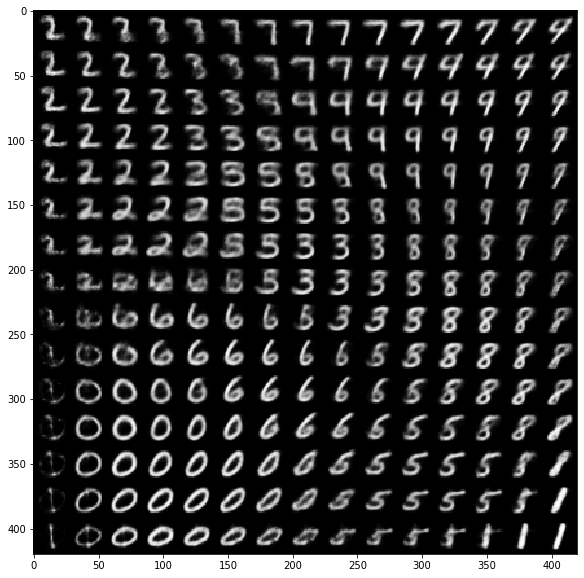

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 1
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

print("grid_x.shape :", grid_x.shape)
print("grid_y.shape :", grid_y.shape)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.show()

### ppf()
`grid_x = norm.ppf(np.linspace(0.05, 0.95, n))`

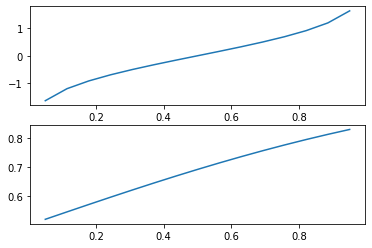

### Decoded image

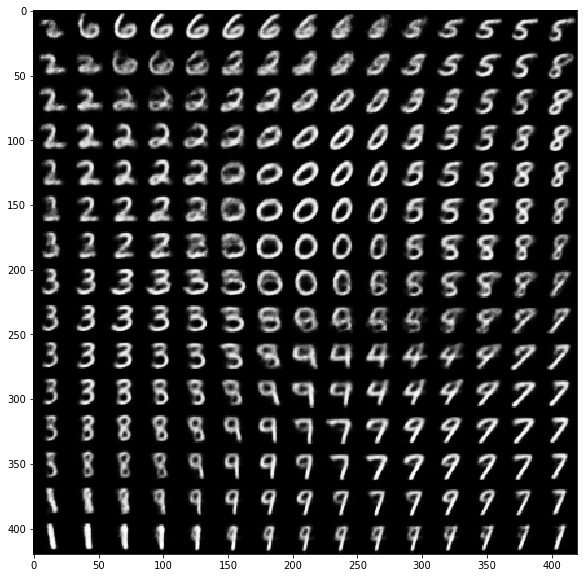

## 실습 과제

### 과제1 : 공용 G-drive 아래 `/models/vae_latent.h5`에 학습 결과를 읽어 실행해 보자
#### -- plot cell에서 `n = 15` 값을 30, 40으로 바꾸어 실행해 보자
#### -- VAE model이 생성하는 손글씨의 다양성을 검토하고,
#### -- 활용가능성을 생각해 보자:


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
vae.load_weights('/content/drive/Shared drives/scsa_2019_e/models/vae_latent.h5')

grid_x.shape : (30,)
grid_y.shape : (30,)


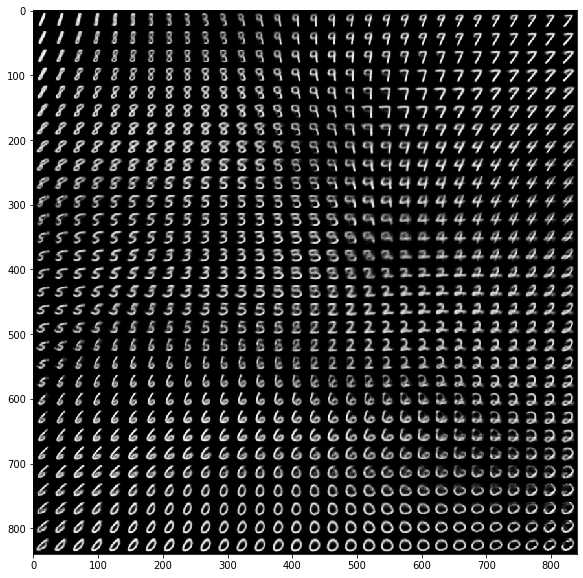

In [0]:
batch_size = 1
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

print("grid_x.shape :", grid_x.shape)
print("grid_y.shape :", grid_y.shape)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.show()

grid_x.shape : (40,)
grid_y.shape : (40,)


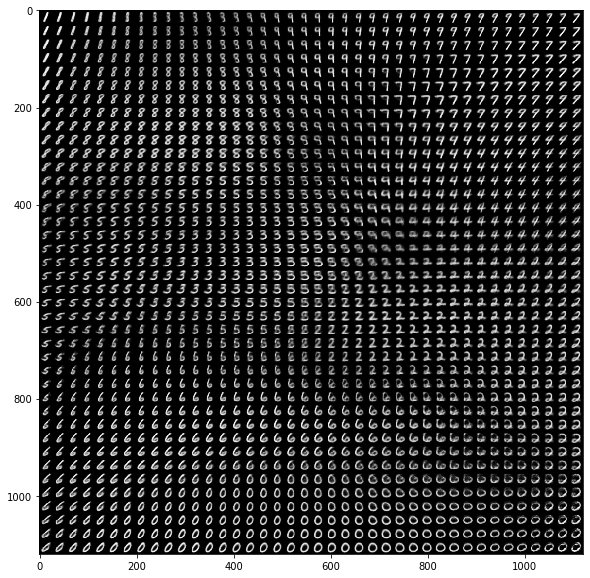

In [0]:
batch_size = 1
n = 40
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

print("grid_x.shape :", grid_x.shape)
print("grid_y.shape :", grid_y.shape)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.show()